<a href="https://colab.research.google.com/github/anelglvz/Matematicas_Ciencia_Datos/blob/main/Bayesiana/Gaussian_Processes_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian processes for Regression


## Implementation with NumPy

We will use the squared exponential kernel, also known as Gaussian kernel or RBF kernel:

$$ κ (x_i,x_j) = σ_f^2 \exp \left( - \frac{1}{2l^2} (x_i - x_j)^T(x_i-x_j) \right)  $$


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def kernel(X1, X2, l=1.0, sigma_f=1.0):
    """
    Isotropic squared exponential kernel.

    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        (m x n) matrix.
    """
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

In [ ]:
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))    # Approximately 95% of the area of a normal distribution is withinn 1.96 times standard error of the mean.

    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()

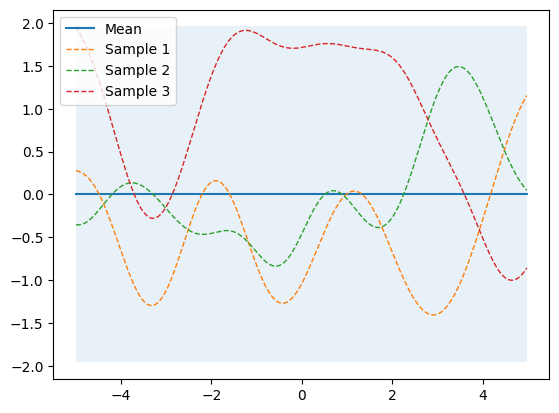

In [ ]:
%matplotlib inline


# Finite number of points
X = np.arange(-5, 5, 0.02).reshape(-1, 1)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = kernel(X, X)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# Plot GP mean, uncertainty region and samples
plot_gp(mu, cov, X, samples=samples)

In [ ]:
samples

array([[ 5.28684601e-02,  1.17132656e-01,  1.32892396e-01,
         8.80090120e-02, -2.03514337e-02, -1.87058025e-01,
        -3.99598086e-01, -6.37910457e-01, -8.74757296e-01,
        -1.07802667e+00, -1.21541796e+00, -1.26067480e+00,
        -1.19959399e+00, -1.03389285e+00, -7.81687766e-01,
        -4.74458819e-01, -1.51449657e-01,  1.46946142e-01,
         3.85279372e-01,  5.37627536e-01,  5.90420443e-01,
         5.43780781e-01,  4.11577854e-01,  2.19822962e-01,
         2.65987519e-03, -2.04239787e-01, -3.71619984e-01,
        -4.83386578e-01, -5.39669948e-01, -5.55241274e-01,
        -5.54224426e-01, -5.63071347e-01, -6.03615266e-01,
        -6.87388334e-01, -8.12078766e-01, -9.61049671e-01,
        -1.10670175e+00, -1.21756359e+00, -1.26744295e+00,
        -1.24350948e+00, -1.14987502e+00, -1.00474973e+00,
        -8.32171724e-01, -6.52092187e-01, -4.73490436e-01,
        -2.93540462e-01, -1.02659531e-01,  1.07549040e-01,
         3.37459268e-01,  5.76713745e-01],
       [-1.08

Given a training dataset with noise-free funtion values $f$ at inputs $X$, a GP prior can be converted into a GP posterior $p(f_*\mid X_*,X,f)$ which can then be used to make predictions $f_*$ at new inputs $X_*$.

By definition of a Gaussian Process, the join distribution of observed values $f$ and predictions $f_*$ is again a Gaussian

$$ p(f_* \mid X_*,X,f) = N(f_* \mid \mu_*, \Sigma_* ) $$

with
$\mu_* = K_*^TK^{-1}f$ y $Σ_* = K_{**}-K_*^TK^{-1}K_*$

where $K=\kappa(X,X)$, $K_* = \kappa (X,X_*)$ and $K_{**} = \kappa (X_*,X_*)$.

If we have a training dataset with noisy function values $y=f+ϵ$ where $ϵ\sim N(0,σ_y^2 I)$ is independently added to each observation then the predictive distribution is given by

$$ p(f_* \mid X_*,X,y) = N(f_*\mid \mu_*,\Sigma_*) $$

where $\mu_* = K_*^T K_y^{-1}y$ and $Σ_* = K_{**}-K_*^T K_y^{-1}K_*$ with $K_y = K+σ_y^2 I$. To additionally include noise $ϵ$ into predictions $y_*$ we have

$$ p(f_* \mid X_*,X,y) = N(y_* \mid \mu_*, \Sigma_*+σ_y^2 I).$$


In [ ]:
from numpy.linalg import inv

def posterior(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    """
    Computes the suffifient statistics of the posterior distribution
    from m training data X_train and Y_train and n new inputs X_s.

    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.

    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    """
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)

    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

    return mu_s, cov_s

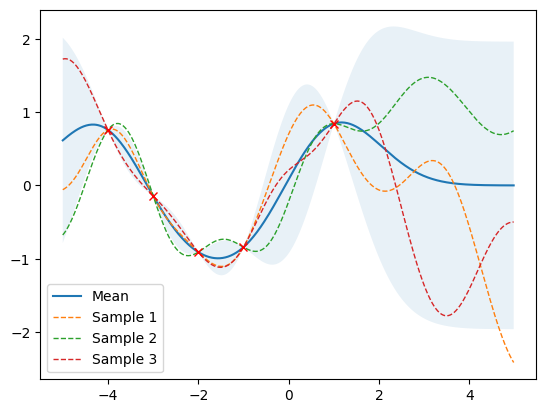

In [ ]:
# Noise free training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
Y_train = np.sin(X_train)

# Compute mean and covariance of the posterior distribution
mu_s, cov_s = posterior(X, X_train, Y_train)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

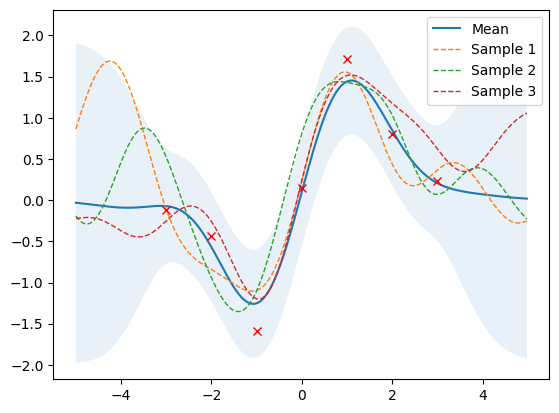

In [ ]:
noise = 0.4

# Noisy training data
X_train = np.arange(-3, 4, 1).reshape(-1, 1)
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

# Compute mean and covariance of the posterior distribution
mu_s, cov_s = posterior(X, X_train, Y_train, sigma_y=noise)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

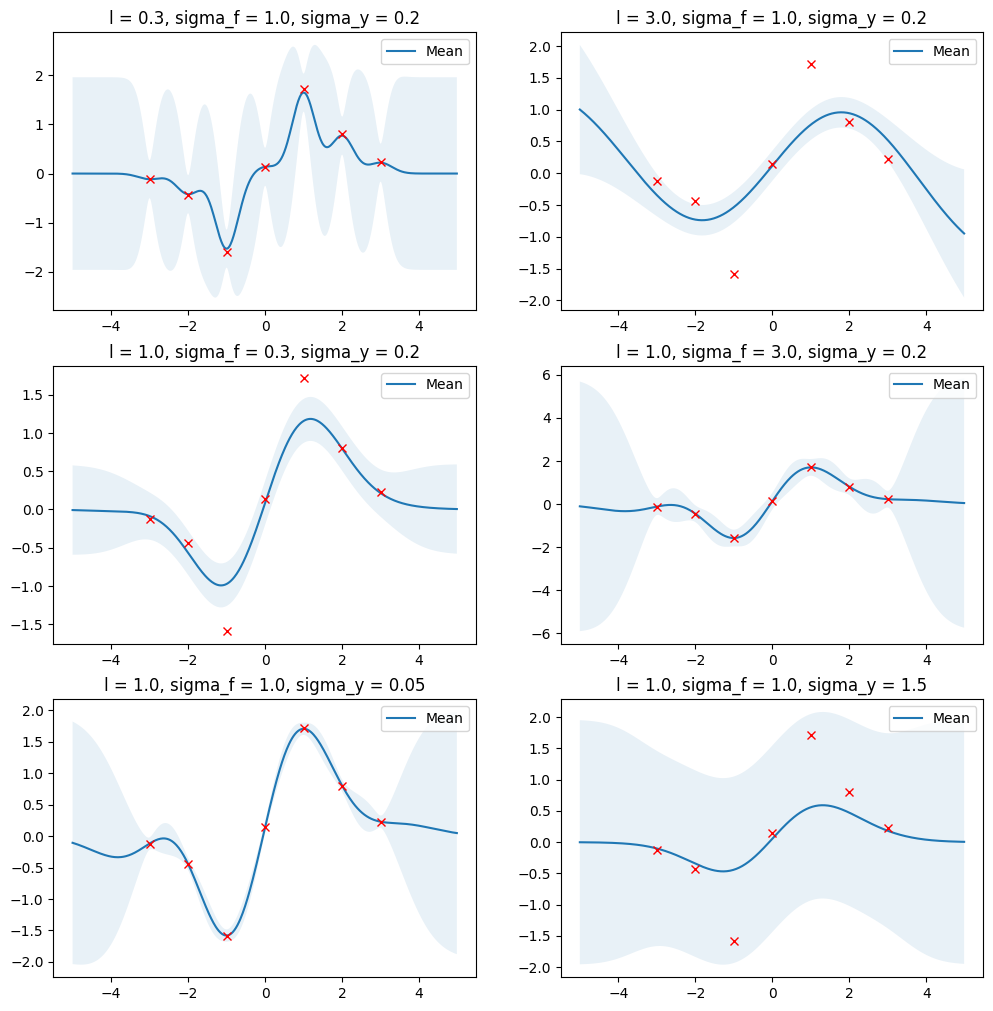

In [ ]:
params = [
    (0.3, 1.0, 0.2),
    (3.0, 1.0, 0.2),
    (1.0, 0.3, 0.2),
    (1.0, 3.0, 0.2),
    (1.0, 1.0, 0.05),
    (1.0, 1.0, 1.5),
]

plt.figure(figsize=(12, 5))

for i, (l, sigma_f, sigma_y) in enumerate(params):
    mu_s, cov_s = posterior(X, X_train, Y_train, l=l,
                            sigma_f=sigma_f,
                            sigma_y=sigma_y)
    plt.subplot(3, 2, i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'l = {l}, sigma_f = {sigma_f}, sigma_y = {sigma_y}')
    plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

Optimal values for these parameters can be estimated by maximizing the log marginal likelihood which is given by

$$ \log p(y\mid X) = \log N(y\mid 0,K_y) = -\frac{1}{2} y^T K_y^{-1} y - \frac{1}{2} \log \vert K_y \vert -\frac{N}{2} \log (2\pi) $$

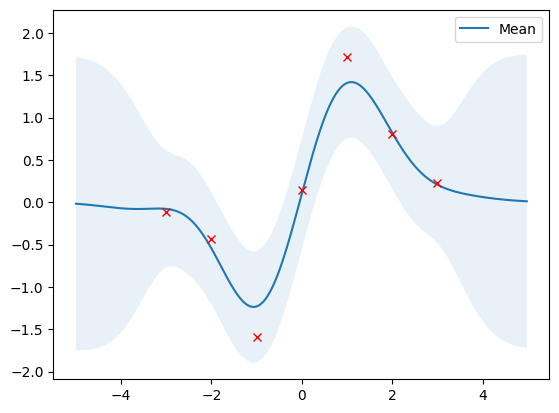

In [ ]:
from numpy.linalg import cholesky, det
from scipy.linalg import solve_triangular
from scipy.optimize import minimize

def nll_fn(X_train, Y_train, noise, naive=True):
    """
    Returns a function that computes the negative log marginal
    likelihood for training data X_train and Y_train and given
    noise level.

    Args:
        X_train: training locations (m x d).
        Y_train: training targets (m x 1).
        noise: known noise level of Y_train.
        naive: if True use a naive implementation of Eq. (11), if
               False use a numerically more stable implementation.

    Returns:
        Minimization objective.
    """

    Y_train = Y_train.ravel()

    def nll_naive(theta):
        # Naive implementation of equation below. Works well for the examples
        # in this article but is numerically less stable compared to
        # the implementation in nll_stable below.
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        return 0.5 * np.log(det(K)) + \
               0.5 * Y_train.dot(inv(K).dot(Y_train)) + \
               0.5 * len(X_train) * np.log(2*np.pi)

    def nll_stable(theta):
        # Numerically more stable implementation of equation below as described
        # in http://www.gaussianprocess.org/gpml/chapters/RW2.pdf, Section
        # 2.2, Algorithm 2.1.

        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        L = cholesky(K)

        S1 = solve_triangular(L, Y_train, lower=True)
        S2 = solve_triangular(L.T, S1, lower=False)

        return np.sum(np.log(np.diagonal(L))) + \
               0.5 * Y_train.dot(S2) + \
               0.5 * len(X_train) * np.log(2*np.pi)

    if naive:
        return nll_naive
    else:
        return nll_stable

# Minimize the negative log-likelihood w.r.t. parameters l and sigma_f.
# We should actually run the minimization several times with different
# initializations to avoid local minima but this is skipped here for
# simplicity.
res = minimize(nll_fn(X_train, Y_train, noise), [1, 1],
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

# Store the optimization results in global variables so that we can
# compare it later with the results from other implementations.
l_opt, sigma_f_opt = res.x

# Compute posterior mean and covariance with optimized kernel parameters and plot the results
mu_s, cov_s = posterior(X, X_train, Y_train, l=l_opt, sigma_f=sigma_f_opt, sigma_y=noise)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

In [ ]:
from matplotlib import animation, cm

def plot_gp_2D(gx, gy, mu, X_train, Y_train, title, i):
    ax = plt.gcf().add_subplot(1, 2, i, projection='3d')
    ax.plot_surface(gx, gy, mu.reshape(gx.shape), cmap=cm.coolwarm, linewidth=0, alpha=0.2, antialiased=False)
    ax.scatter(X_train[:,0], X_train[:,1], Y_train, c=Y_train, cmap=cm.coolwarm)
    ax.set_title(title)


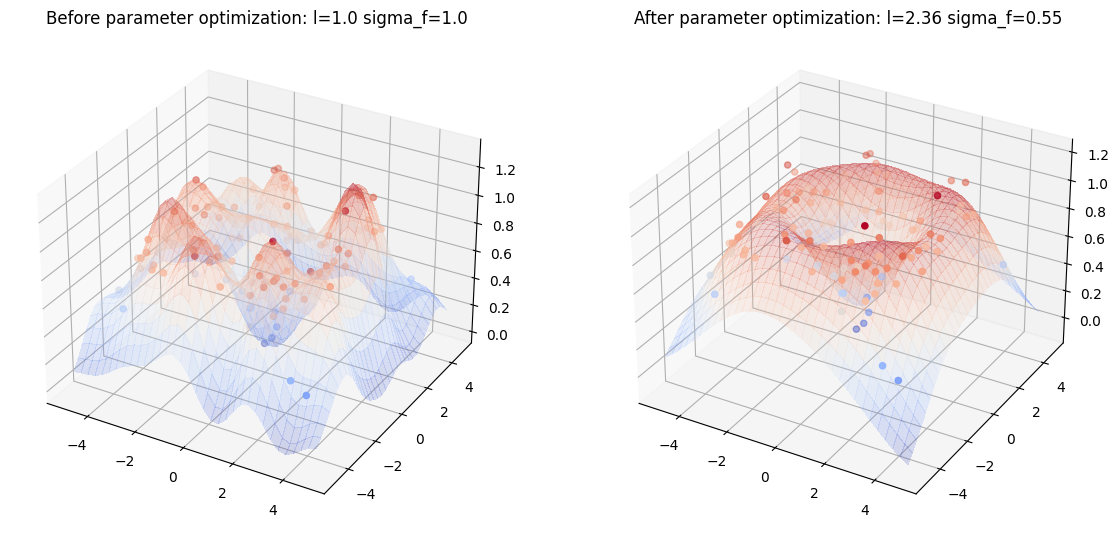

In [ ]:
noise_2D = 0.1

rx, ry = np.arange(-5, 5, 0.3), np.arange(-5, 5, 0.3)
gx, gy = np.meshgrid(rx, rx)

X_2D = np.c_[gx.ravel(), gy.ravel()]

X_2D_train = np.random.uniform(-4, 4, (100, 2))
Y_2D_train = np.sin(0.5 * np.linalg.norm(X_2D_train, axis=1)) + \
             noise_2D * np.random.randn(len(X_2D_train))

plt.figure(figsize=(14,7))

mu_s, _ = posterior(X_2D, X_2D_train, Y_2D_train, sigma_y=noise_2D)
plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train,
           f'Before parameter optimization: l={1.00} sigma_f={1.00}', 1)

res = minimize(nll_fn(X_2D_train, Y_2D_train, noise_2D), [1, 1],
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

mu_s, _ = posterior(X_2D, X_2D_train, Y_2D_train, *res.x, sigma_y=noise_2D)
plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train,
           f'After parameter optimization: l={res.x[0]:.2f} sigma_f={res.x[1]:.2f}', 2)

## Libraries that implement Gaussian processes

True
True


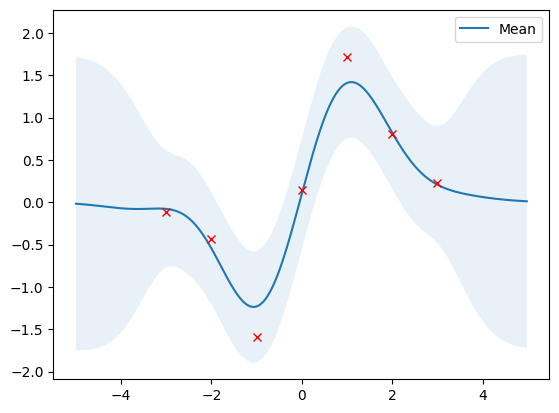

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=rbf, alpha=noise**2)

# Reuse training data from previous 1D example
gpr.fit(X_train, Y_train)

# Compute posterior mean and covariance
mu_s, cov_s = gpr.predict(X, return_cov=True)

# Obtain optimized kernel parameters
l = gpr.kernel_.k2.get_params()['length_scale']
sigma_f = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])

# Compare with previous results
print(np.isclose(l_opt, l))
print(np.isclose(sigma_f_opt, sigma_f))

# Plot the results
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

In [ ]:
!pip install GPy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.4/959.4 kB 47.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for GPy: filename=GPy-1.10.0-cp310-cp310-linux_x86_64.whl size=3296983 sha256=5a96d75a7844eaea3e35ffea6bfbed0d5c36b01fe14bbb0dc5183bcfcb04412e
  Stored in directory: /root/.cache/pip/wheels/27/bd/9f/82ab4216eae088cba864ca0dc1d75699bd4bf6823790fb2f77
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102548 sha256=4af6bf3daef6905280401989d946df03b81eaa87abb3873b8f43f80319da9a1a
  Stored in directory: /root/.cache/pip/wheels/d2/ef/9c/da9ceef7d0ff5287c24365844fc394852c2b79ac3fcf33bf8b
Successfully built GPy paramz


In [ ]:
import GPy

rbf = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
gpr = GPy.models.GPRegression(X_train, Y_train, rbf)

# Fix the noise variance to known value
gpr.Gaussian_noise.variance = noise**2
gpr.Gaussian_noise.variance.fix()

# Run optimization
gpr.optimize();

# Display optimized parameter values
display(gpr)

GP_regression.,value,constraints,priors
rbf.variance,0.27914495747500306,+ve,
rbf.lengthscale,1.8472451333488968,+ve,
Gaussian_noise.variance,0.16000000000000003,+ve fixed,


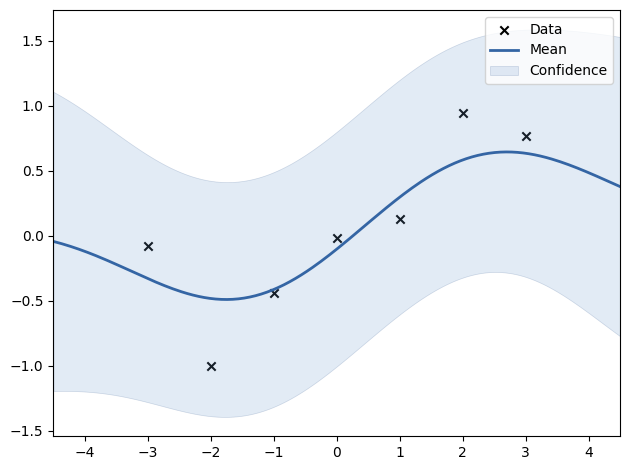

In [ ]:
# Obtain optimized kernel parameters
l = gpr.rbf.lengthscale.values[0]
sigma_f = np.sqrt(gpr.rbf.variance.values[0])

# Compare with previous results
assert(np.isclose(l_opt, l))
assert(np.isclose(sigma_f_opt, sigma_f))

# Plot the results with the built-in plot function
gpr.plot();

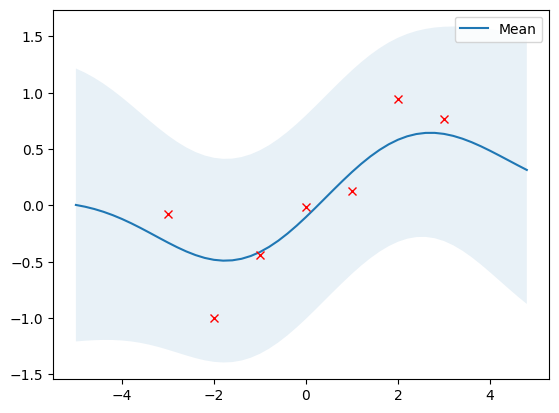

In [ ]:
mu_s, cov_s = posterior(X, X_train, Y_train, l=l_opt, sigma_f=sigma_f_opt, sigma_y=noise)

# Include noise into predictions
cov_s = cov_s + noise**2 * np.eye(*cov_s.shape)

plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

Reference:
https://www.apps.stat.vt.edu/leman/VTCourses/GPtutorial.pdf